In [18]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [19]:
file_path = '/kaggle/input/gripper-sim/Gripper_simulation_result.csv'
data = pd.read_csv(file_path)

X = data.drop(columns=['result','index'])
y = data['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

In [21]:
X_train_scale

array([[-0.66409467,  0.51160049, -1.47557486, ..., -2.02386509,
        -0.4067472 ,  0.74408531],
       [-0.03077272,  0.23221547,  1.71387246, ...,  2.07584736,
        -0.73801074, -0.10309796],
       [-1.28848509, -0.29068672,  1.11893976, ...,  1.4061756 ,
         0.15796707,  1.13825202],
       ...,
       [ 0.82449282,  1.46247608,  0.585436  , ...,  0.34336601,
        -1.28982607, -0.3673564 ],
       [-1.32333717,  0.01642449, -1.09905594, ..., -1.46137395,
        -0.00341476,  1.15350583],
       [ 0.54096119,  0.92359361, -1.33798058, ..., -0.92205327,
        -1.17903222, -0.55056518]])

In [22]:
model = nn.Sequential(
    nn.Linear(7, 1000),
    nn.ReLU(),
    #nn.Dropout(0.2),
    nn.Linear(1000, 1000),
    nn.ReLU(),
    nn.Linear(1000, 1),
    nn.Sigmoid(),
)
    
    #model = model.to(device)
    
    # loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error ,weight_decay=1e-5
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 100  # number of epochs to run
batch_size = 32  # size of each batch
batch_start = torch.arange(0, len(X_train_scale), batch_size)
best_bse = np.inf

In [23]:
best_weights = None
history_test = []
history_train = []
history_val = []
start = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


X_train = torch.tensor(X_train_scale, dtype=torch.float32,device=device)
y_train = torch.tensor(y_train.values, dtype=torch.float32,device=device)
X_test = torch.tensor(X_test_scale, dtype=torch.float32,device=device)
y_test = torch.tensor(y_test.values, dtype=torch.float32,device=device)

In [24]:
X_train.shape

torch.Size([8800, 7])

In [25]:
for epoch in range(n_epochs):
    model.train()
    permutation = torch.randperm(X_train.size()[0])
    for batch in range(0,X_train.size()[0], batch_size): 
        indices = permutation[batch:batch+batch_size]
        X_batch, y_batch = X_train[indices], y_train[indices]
        # forward pass
        y_pred = model(X_batch)
        y_pred = torch.reshape(y_pred, y_batch.shape)
        loss = loss_fn(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
    history_train.append(float(loss))
        
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred = torch.reshape(y_pred, y_test.shape)
        test_loss = loss_fn(y_pred, y_test)
        test_loss = float(test_loss)
        history_test.append(test_loss)
        acc = (y_pred.round() == y_test).float().mean()
    print(f'Train Epoch: {epoch} ' f'Train Loss: {round(float(loss),4)} ' f' Test Loss: {round(test_loss,4)} ' f' Accuracy: {round(float(acc),4)}%')
    if test_loss < best_bse:
        best_bse = test_loss
        best_weights = copy.deepcopy(model.state_dict())

Train Epoch: 0 Train Loss: 0.4635  Test Loss: 0.4858  Accuracy: 0.8041%
Train Epoch: 1 Train Loss: 0.3395  Test Loss: 0.448  Accuracy: 0.8323%
Train Epoch: 2 Train Loss: 0.353  Test Loss: 0.4397  Accuracy: 0.8295%
Train Epoch: 3 Train Loss: 0.4615  Test Loss: 0.4189  Accuracy: 0.8377%
Train Epoch: 4 Train Loss: 0.4896  Test Loss: 0.4251  Accuracy: 0.8418%
Train Epoch: 5 Train Loss: 0.3986  Test Loss: 0.3997  Accuracy: 0.8436%
Train Epoch: 6 Train Loss: 0.3394  Test Loss: 0.3839  Accuracy: 0.8505%
Train Epoch: 7 Train Loss: 0.5099  Test Loss: 0.3946  Accuracy: 0.85%
Train Epoch: 8 Train Loss: 0.2668  Test Loss: 0.3955  Accuracy: 0.8323%
Train Epoch: 9 Train Loss: 0.4727  Test Loss: 0.3903  Accuracy: 0.8459%
Train Epoch: 10 Train Loss: 0.2938  Test Loss: 0.378  Accuracy: 0.8386%
Train Epoch: 11 Train Loss: 0.2973  Test Loss: 0.4108  Accuracy: 0.8373%
Train Epoch: 12 Train Loss: 0.5192  Test Loss: 0.3912  Accuracy: 0.8382%
Train Epoch: 13 Train Loss: 0.3735  Test Loss: 0.3913  Accuracy: 0

Best BSE: 0.3274
RBSE: 0.5722
Total Epoch Trained: 0


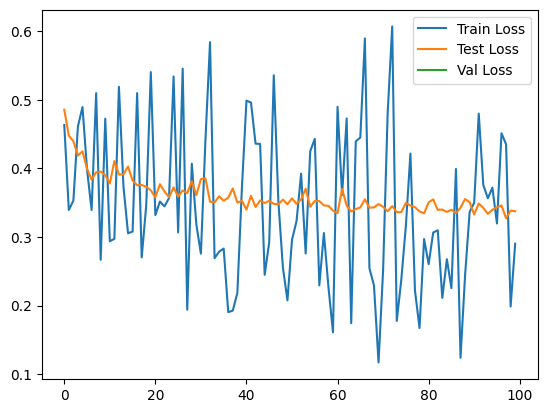

In [26]:
model.load_state_dict(best_weights)
total_epoch = len(history_val)
print("Best BSE: %.4f" % best_bse)
print("RBSE: %.4f" % np.sqrt(best_bse))
print("Total Epoch Trained: " + str(total_epoch))
plt.plot(history_train,label="Train Loss")
plt.plot(history_test,label="Test Loss")
plt.plot(history_val,label="Val Loss")
plt.legend(loc="upper right")
plt.savefig("/kaggle/working/test.svg")
plt.show()

In [27]:
torch.save(model.state_dict(), "/kaggle/working/model_" + str(round(best_bse,4)) + ".pth")